In [39]:
import json
import BinParser
import uproot
import pickle
import numpy as np
import pandas as pd
import icarusplot
import os

In [40]:
WD = '/Users/jskim/Documents/Neutrino/ICARUS/GUNDAM-1.9.X/work/CovMat'

In [41]:
PlotDir = f'{WD}/plots'
os.system('mkdir -p '+PlotDir)

0

In [42]:
OutDir = f'{WD}/outputs'
os.system('mkdir -p '+OutDir)

0

In [43]:
NMaxToWriteText = 12

In [44]:
ConfigFileName = 'config_G4PipFate.json'
# ConfigFileName = 'config_G4PimFate.json'
# ConfigFileName = 'config_G4ProtonFate.json'

# ConfigFileName = 'config_GENIE_fsi_N_TrueMuonCos.json'
# ConfigFileName = 'config_GENIE_fsi_pi_TrueMuonCos.json'

# ConfigFileName = 'config_GENIE_fsi_N_TrueMuonProtonCos.json'
# ConfigFileName = 'config_GENIE_fsi_pi_TrueMuonProtonCos.json'

# ConfigFileName = 'config_GENIE_fsi_pi_TrueMuonProtonCos_vs_TrueMuonCos.json'
# ConfigFileName = 'config_GENIE_fsi_N_TrueMuonProtonCos_vs_TrueMuonCos.json'

# ConfigFileName = 'config_GENIE_fsi_N_TruedeltaPT.json'
# ConfigFileName = 'config_GENIE_fsi_pi_TruedeltaPT.json'

# ConfigFileName = 'config_GENIE_fsi_pi_TruedeltaalphaT.json'
# ConfigFileName = 'config_GENIE_fsi_N_TruedeltaalphaT.json'

# ConfigFileName = 'config_GENIE_fsi_pi_TruedeltaalphaT_vs_TruedeltaPT.json'
# ConfigFileName = 'config_GENIE_fsi_N_TruedeltaalphaT_vs_TruedeltaPT.json'

f_json = open(ConfigFileName)
json_config = json.load(f_json)

In [45]:
json_MainTree = json_config['MainTree']

# Input file
InputFileName = json_MainTree['FilePath']
TreeKey = json_MainTree['TreeKey']
print('- InputFileName: %s'%(InputFileName))
print('- TreeKey: %s'%(TreeKey))

with open(InputFileName, 'rb') as f:
    data_dict = pickle.load(f)

df = data_dict[TreeKey]

# if '/' in TreeKey:

#     with open(InputFileName, 'rb') as f:
#         data_dict = pickle.load(f)

#     del data_dict['TrueDFs']

#     df = data_dict['RecoDFs']['BeamMC']

#     # clean up
#     data_dict_keysList = list(data_dict['RecoDFs'].keys())
#     for key in data_dict_keysList:
#         if key != 'BeamMC':
#             del data_dict['RecoDFs'][key]

# else:

#     with open(InputFileName, 'rb') as f:
#         data_dict = pickle.load(f)

#     df = data_dict[TreeKey]

- InputFileName: /Users/jskim/Documents/Neutrino/ICARUS/NuMINumuXSec/NuMIPyAna/EventSelectionPlots/inputfiles/250627_BadRegionRejection/RecoTree_NuMI_MC_Nu_Phase2_2023ANuMIReproc_CAFTypeCommonRemerge_ReNuSyst250403_WithTrackSplit_BNBFixedProb.pkl
- TreeKey: RecoTree


In [46]:
# Cut and Sample selection

SelectionCutExpr = json_config['SelectionCutExpr']
SampleSelectionExpr = json_config['SampleSelectionExpr']
SampleWeightExpr = json_config['SampleWeightExpr']
print('- Selection cut: %s'%(SelectionCutExpr))
print('- Sample selection: %s'%(SampleSelectionExpr))
print('- Sample weight: %s'%(SampleWeightExpr))


- Selection cut: CutType==1 | CutType==2
- Sample selection: IsSignal!=5
- Sample weight: FluxWeightWithBeamWidthCorrection * SPPQ2RW * SPPTpiMINERvAFittedReweight


In [47]:
# Evaluate the weight expr
df = df.eval('FinalWeight = %s'%(SampleWeightExpr))

In [48]:
# Binning
BinningFile = json_config['BinningFile']
print('- Binning from %s:'%(BinningFile))
bin_parser = BinParser.BinParser(BinningFile)
NBins = len(bin_parser.CutExprs)
for i_Cut, CutExpr in enumerate(bin_parser.CutExprs):
    print('bin %d: '%(i_Cut), CutExpr)

- Binning from /Users/jskim/Documents/Neutrino/ICARUS/GUNDAM-1.9.X/work/binnings/binning_G4PipFate.txt:
[BinParser][__init__] Reading binning info from /Users/jskim/Documents/Neutrino/ICARUS/GUNDAM-1.9.X/work/binnings/binning_G4PipFate.txt
Variable name: TrueNpipAll, Type: float
bin 0:  TrueNpipAll>=1 & TrueNpipAll<2
bin 1:  TrueNpipAll>=2 & TrueNpipAll<999


In [49]:
# Get Nominal histogram
h_Nom = np.zeros(NBins)
for i_Cut, CutExpr in enumerate(bin_parser.CutExprs):
    this_CutExpr = '(%s) & (%s) & (%s)'%(SelectionCutExpr, SampleSelectionExpr, CutExpr)
    this_WeightExpr = 'FinalWeight'

    this_bincontent = np.sum( df.query(this_CutExpr)[this_WeightExpr]  )

    h_Nom[i_Cut] = this_bincontent
print(h_Nom)
    

[13508.57712812  3346.78318797]


In [50]:
JobName = json_config['JobName']
DialName = json_config['DialName']
NUniv = json_config['NUniv']

print('JobName = ', JobName)
print('DialName = ', DialName)
print('NUniv = ', NUniv)

RW_ndarray = np.array(df[DialName].tolist())

h_Univs = np.zeros((NUniv, NBins))

for i_Cut, CutExpr in enumerate(bin_parser.CutExprs):
    this_CutExpr = '(%s) & (%s) & (%s)'%(SelectionCutExpr, SampleSelectionExpr, CutExpr)
    this_WeightExpr = 'FinalWeight'

    df_Selected = df.query(this_CutExpr)
    RW_ndarray = np.array(df_Selected[DialName].tolist())

    for Univ in range(NUniv):
        this_bincontent = np.sum( df_Selected[this_WeightExpr] *  RW_ndarray[:, Univ] )
        h_Univs[Univ][i_Cut] = this_bincontent

    del df_Selected


JobName =  G4PipFate
DialName =  reinteractions_piplus_Geant4
NUniv =  1000


In [51]:
h_Univs[0]

array([13489.17967499,  3398.56432913])

In [52]:
h_Mean = np.mean(h_Univs, axis=0)

In [53]:
h_Mean

array([13528.09459801,  3346.03333904])

In [54]:
h_Cov = np.zeros((NBins, NBins))
for i in range(NBins):
    for j in range(NBins):
        h_Cov[i][j] = np.sum((h_Univs[:, i] - h_Mean[i]) * (h_Univs[:, j] - h_Mean[j])) / (NUniv - 1) / h_Mean[i] / h_Mean[j]

        ## TODO
        # if i==j:
        #     h_Cov[i][j] += np.random.rand() * 1E-6

h_Corr = np.zeros((NBins, NBins))
for i in range(NBins):
    for j in range(NBins):
        h_Corr[i][j] = h_Cov[i][j] / np.sqrt( h_Cov[i, i] ) / np.sqrt( h_Cov[j, j] )

In [55]:
import ROOT

OutputFileName = json_config['OutputFileName']
f_out = ROOT.TFile(f'{OutDir}/{OutputFileName}', 'RECREATE')

h_Cov_TMat = ROOT.TMatrixDSym(NBins)
for i in range(NBins):
    for j in range(NBins):
        h_Cov_TMat[i][j] = h_Cov[i, j]
h_Cov_TMat.SetTol(1E-20)

print(h_Cov_TMat.Determinant())

h_Corr_TMat = ROOT.TMatrixDSym(NBins)
for i in range(NBins):
    for j in range(NBins):
        h_Corr_TMat[i][j] = h_Corr[i, j]
h_Corr_TMat.SetTol(1E-20)

f_out.mkdir(JobName)
f_out.cd(JobName)
h_Cov_TMat.Write('%s_covariance'%(JobName))
h_Corr_TMat.Write('%s_correlation'%(JobName))

f_out.cd()
f_out.Close()

1.1344634160672312e-08


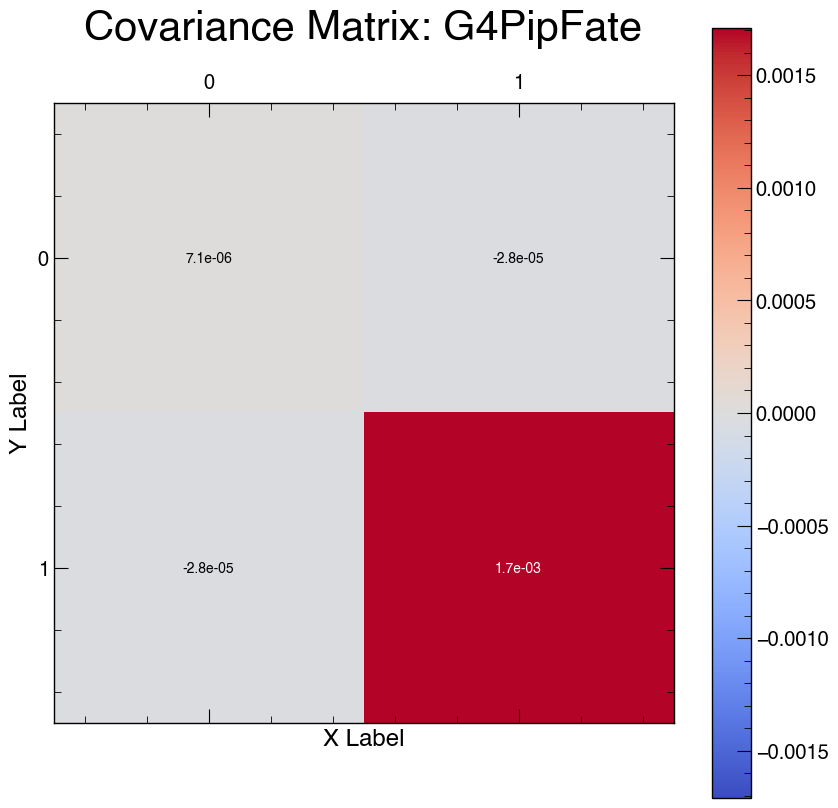

In [56]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

# Plot the heatmap
cax = ax.matshow(h_Cov, cmap='coolwarm')

# Add colorbar
plt.colorbar(cax)

cax_lims = cax.get_clim()
cax_max = max( abs(cax_lims[0]), abs(cax_lims[1]) )
cax.set_clim(-1.*cax_max, +1*cax_max)
cax_use_red = 0.75*cax_max

# Add text annotations for each cell
if h_Cov.shape[0]<NMaxToWriteText:
    for i in range(h_Cov.shape[0]):
        for j in range(h_Cov.shape[1]):
            if h_Cov[i, j]>cax_use_red:
                ax.text(j, i, '%1.1e'%(h_Cov[i, j]), ha='center', va='center', color='white')
            else:
                ax.text(j, i, '%1.1e'%(h_Cov[i, j]), ha='center', va='center', color='k')
# Set labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_title('Covariance Matrix: %s'%(JobName), fontsize=30)

# Show plot
plt.show()

fig.savefig(f'{PlotDir}/CovMat_%s.pdf'%(JobName), bbox_inches='tight')

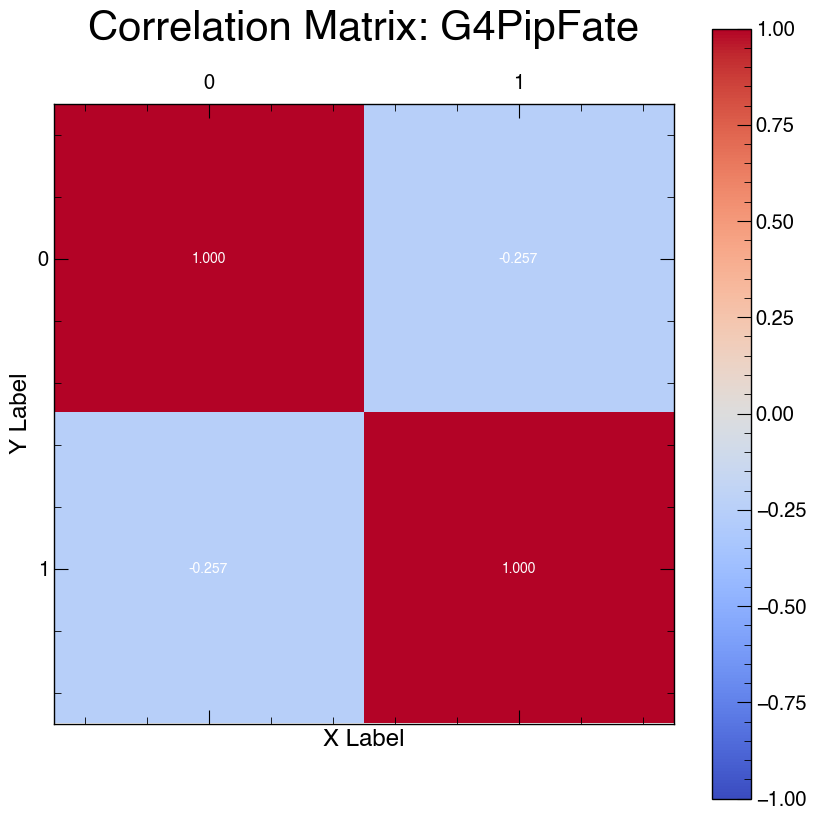

In [57]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

# Plot the heatmap
cax = ax.matshow(h_Corr, cmap='coolwarm')

# Add colorbar
plt.colorbar(cax)
cax.set_clim(-1, +1)
cax_use_red = 0.75*cax_max

# Add text annotations for each cell
if h_Corr.shape[0]<NMaxToWriteText:
    for i in range(h_Corr.shape[0]):
        for j in range(h_Corr.shape[1]):
            if abs(h_Corr[i, j])>cax_use_red:
                ax.text(j, i, '%1.3f'%(h_Corr[i, j]), ha='center', va='center', color='white')
            else:
                ax.text(j, i, '%1.3f'%(h_Corr[i, j]), ha='center', va='center', color='k')
# Set labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_title('Correlation Matrix: %s'%(JobName), fontsize=30)


# Show plot
plt.show()

fig.savefig(f'{PlotDir}/CorrMat_%s.pdf'%(JobName), bbox_inches='tight')
